#SES

In [46]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks/PTDLKD/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PTDLKD/Project


In [47]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [52]:
def load_crypto(filepath):
    df = pd.read_csv(filepath)

    for col in ['Price', 'Open']:
      df[col] = df[col].str.replace(',', '', regex=False).astype(float)

    df['Vol.'] = df['Vol.'].apply(convert_volume)

    # Đổi Date sang datetime và đặt làm index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    print("Data shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df[['Price', 'Open', 'Vol.']].head())

    # Kiểm tra số lượng dữ liệu
    print(f"Tổng số dữ liệu: {len(df)} dòng")

    return df

In [36]:
def split_train_test(data_df, ratio):
    train_size = int(len(data_df) * ratio)
    train_data = data_df[:train_size].copy()
    test_data = data_df[train_size:].copy()
    return train_data, test_data

In [42]:
# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        return float(val)

##Bitcoin Dataset

In [59]:
df = load_crypto('Bitcoin Historical Data.csv')

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  415.8  412.8  55740.0
2016-03-11  419.1  415.8  60630.0
2016-03-12  410.4  419.1  59640.0
2016-03-13  412.4  410.4  34980.0
2016-03-14  414.3  412.4  49330.0
Tổng số dữ liệu: 3370 dòng


In [64]:
# Lấy cột Price để làm đầu vào và Price làm đầu ra
input_features = df[['Price']].values
target_feature = df[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

# Create a new DataFrame with scaled 'Price' and the original 'Date'
# This is needed because the split_train_test function and subsequent plotting
# expect a DataFrame with 'Date' and 'Price' columns.
scaled_df = df.copy()
scaled_df['Price'] = scaled_input
# Reset the index so 'Date' becomes a column again
scaled_df.reset_index(inplace=True)

### Chia 7:3

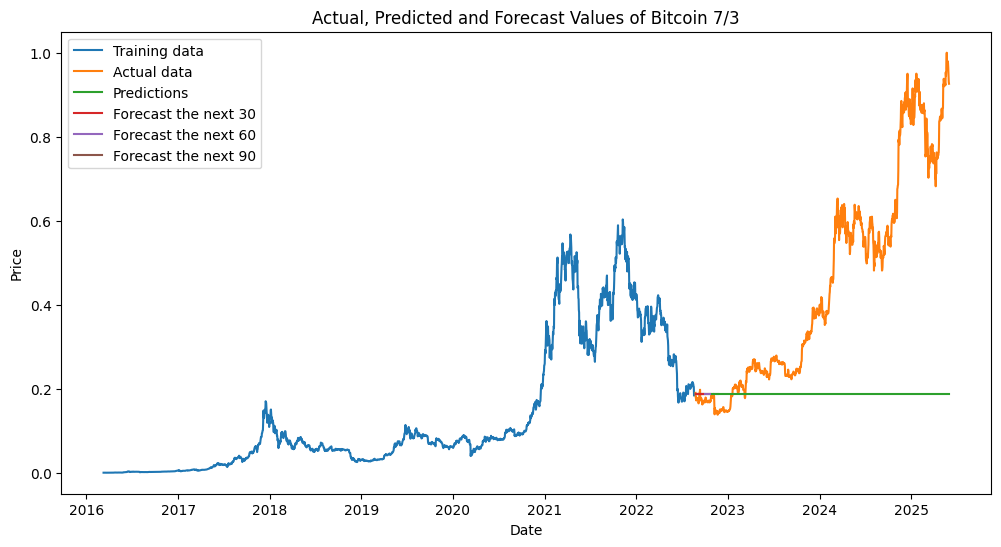

RMSE: 0.3631
MAPE: 0.47%
MSE: 0.1319


In [61]:
train_df, test_df = split_train_test(scaled_df, 0.7)

# The SimpleExpSmoothing model should be trained on the 'Price' column of the training data
model_df = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model_df.forecast(len(test_df))

# The forecast index should correspond to the test set dates
forecast_df = model_df.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)

forecast_df_60 = model_df.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model_df.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)


plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
# Align predictions with the test set dates for plotting
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Bitcoin 7/3') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

### Chia 8:2

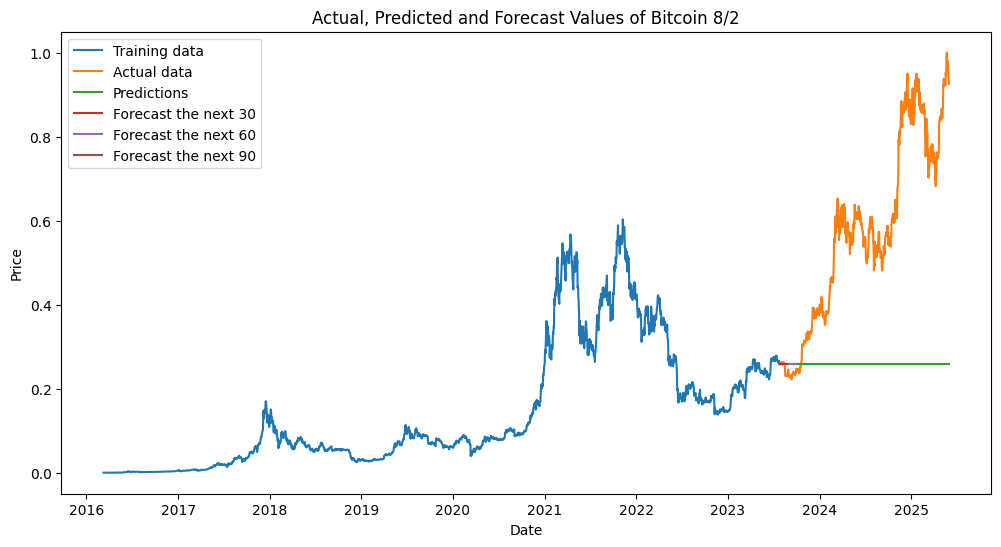

RMSE: 0.3835
MAPE: 0.48%
MSE: 0.1470


In [62]:
# Use scaled_model_df for splitting, as it now has 'Date' as a column
train_df, test_df = split_train_test(scaled_df, 0.8)

model = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model.forecast(len(test_df))

forecast_df = model.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)


forecast_df_60 = model.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Bitcoin 8/2') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

###Chia 9:1

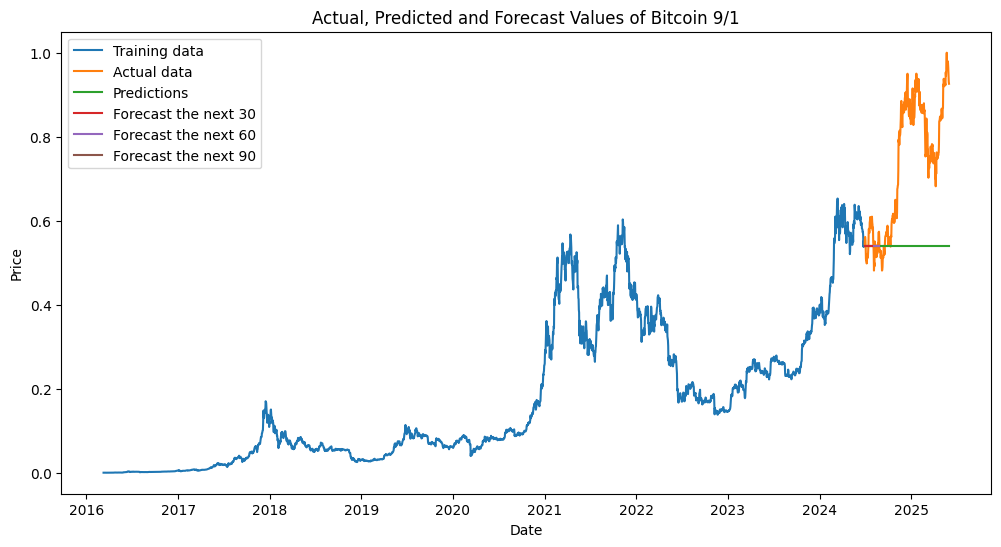

RMSE: 0.2461
MAPE: 0.24%
MSE: 0.0605


In [63]:
train_df, test_df = split_train_test(scaled_df, 0.9)

model = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model.forecast(len(test_df))

forecast_df = model.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)

forecast_df_60 = model.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Bitcoin 9/1') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

##Ethereum

In [65]:
df = load_crypto('Ethereum Historical Data.csv')
# Lấy cột Price để làm đầu vào và Price làm đầu ra
input_features = df[['Price']].values
target_feature = df[['Price']].values

# Áp dụng MinMaxScaler cho input features
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler_input.fit_transform(input_features)

# Áp dụng MinMaxScaler cho target feature
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target_feature)

# Create a new DataFrame with scaled 'Price' and the original 'Date'
# This is needed because the split_train_test function and subsequent plotting
# expect a DataFrame with 'Date' and 'Price' columns.
scaled_df = df.copy()
scaled_df['Price'] = scaled_input
# Reset the index so 'Date' becomes a column again
scaled_df.reset_index(inplace=True)

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  11.75  11.20      0.0
2016-03-11  11.95  11.75    180.0
2016-03-12  12.92  11.95    830.0
2016-03-13  15.07  12.92   1300.0
2016-03-14  12.50  15.07  92180.0
Tổng số dữ liệu: 3370 dòng


### Chia 7:3

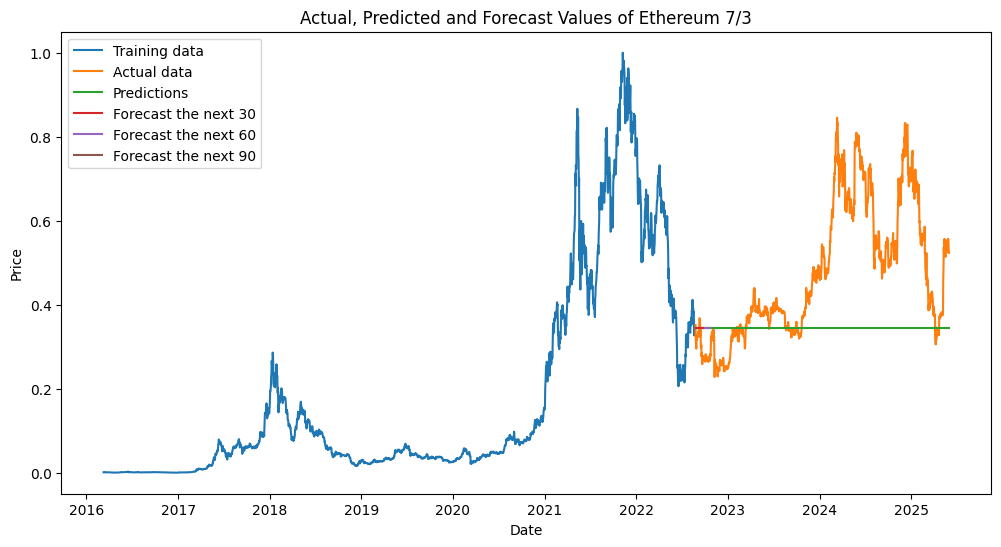

RMSE: 0.2051
MAPE: 0.27%
MSE: 0.0421


In [67]:
train_df, test_df = split_train_test(scaled_df, 0.7)

# The SimpleExpSmoothing model should be trained on the 'Price' column of the training data
model_df = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model_df.forecast(len(test_df))

# The forecast index should correspond to the test set dates
forecast_df = model_df.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)

forecast_df_60 = model_df.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model_df.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)


plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
# Align predictions with the test set dates for plotting
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Ethereum 7/3') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

### Chia 8:2

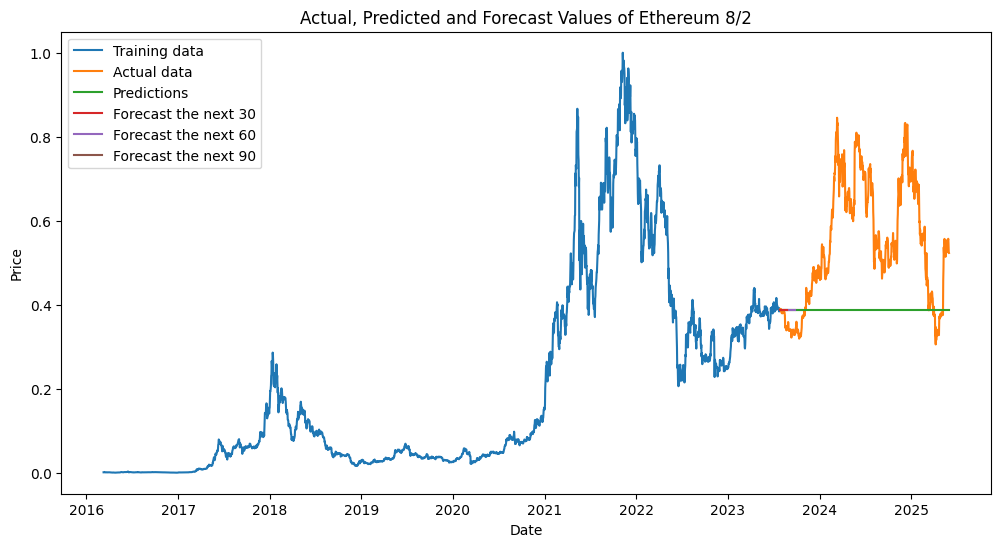

RMSE: 0.2148
MAPE: 0.28%
MSE: 0.0462


In [70]:
train_df, test_df = split_train_test(scaled_df, 0.8)

# The SimpleExpSmoothing model should be trained on the 'Price' column of the training data
model_df = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model_df.forecast(len(test_df))

# The forecast index should correspond to the test set dates
forecast_df = model_df.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)

forecast_df_60 = model_df.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model_df.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)


plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
# Align predictions with the test set dates for plotting
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Ethereum 8/2') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

###Chia 9:1

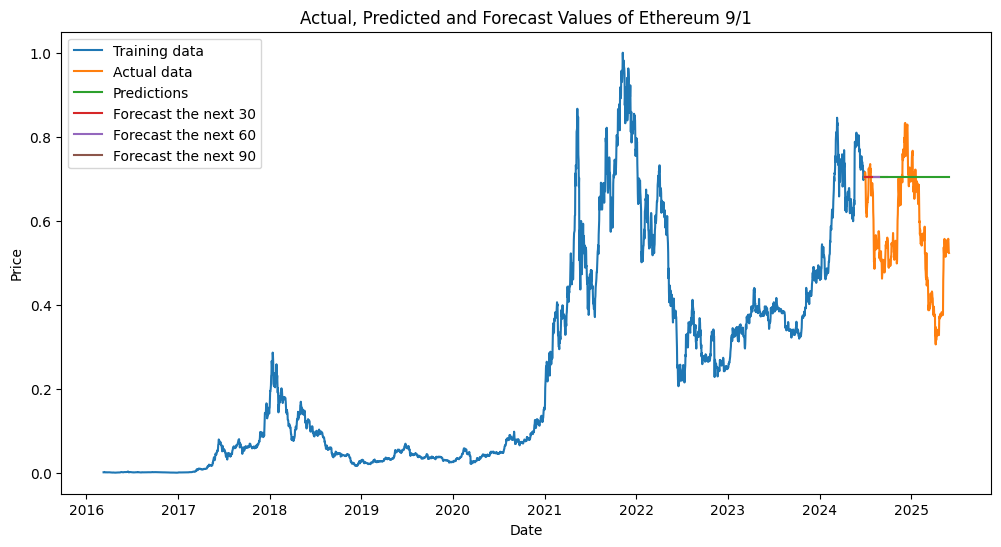

RMSE: 0.1881
MAPE: 0.34%
MSE: 0.0354


In [71]:
train_df, test_df = split_train_test(scaled_df, 0.9)

# The SimpleExpSmoothing model should be trained on the 'Price' column of the training data
model_df = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model_df.forecast(len(test_df))

# The forecast index should correspond to the test set dates
forecast_df = model_df.forecast(30)
# Ensure last_date_df is from the train_df to get the date *before* the test set starts for future forecasting
last_date_train = train_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=30)

forecast_df_60 = model_df.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=60)

forecast_df_90 = model_df.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_train + pd.DateOffset(1), periods=90)


plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
# Align predictions with the test set dates for plotting
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Price') # Changed ylabel to 'Price' as we are plotting the scaled Price
plt.title('Actual, Predicted and Forecast Values of Ethereum 9/1') # Corrected title
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

##XRP

In [80]:
# Đọc file XRP
df = pd.read_csv('XRP Historical Data.csv')

# Loại bỏ dấu phẩy và chuyển đổi thành float cho các cột Price và Open
for col in ['Price', 'Open']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)


# Áp dụng xử lý cho cột 'Vol.'
df['Vol.'] = df['Vol.'].apply(convert_volume)

# Kiểm tra NaN trước xử lý
print(f"Trước khi xử lý, số NaN ở Vol.: {df['Vol.'].isna().sum()}")

# Nội suy và điền 0 nếu còn thiếu
df['Vol.'] = df['Vol.'].interpolate(method='linear')
df['Vol.'] = df['Vol.'].fillna(0)

# Kiểm tra NaN sau xử lý
print(f"Sau khi xử lý, số NaN ở Vol.: {df['Vol.'].isna().sum()}")

# Chuyển cột Date sang datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.reset_index(inplace=True)


# Thông tin dữ liệu
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df[['Price', 'Open', 'Vol.', 'Date']].head()) # Include Date in head print for verification

print(f"Tổng số dữ liệu: {len(df)} dòng")

Trước khi xử lý, số NaN ở Vol.: 12
Sau khi xử lý, số NaN ở Vol.: 0
Data shape: (3369, 7)
Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
    Price    Open     Vol.       Date
0  0.0082  0.0081  59130.0 2016-03-10
1  0.0092  0.0082  25820.0 2016-03-11
2  0.0081  0.0092  78230.0 2016-03-12
3  0.0082  0.0081    620.0 2016-03-13
4  0.0083  0.0082  19310.0 2016-03-14
Tổng số dữ liệu: 3369 dòng


### Chia 7:3

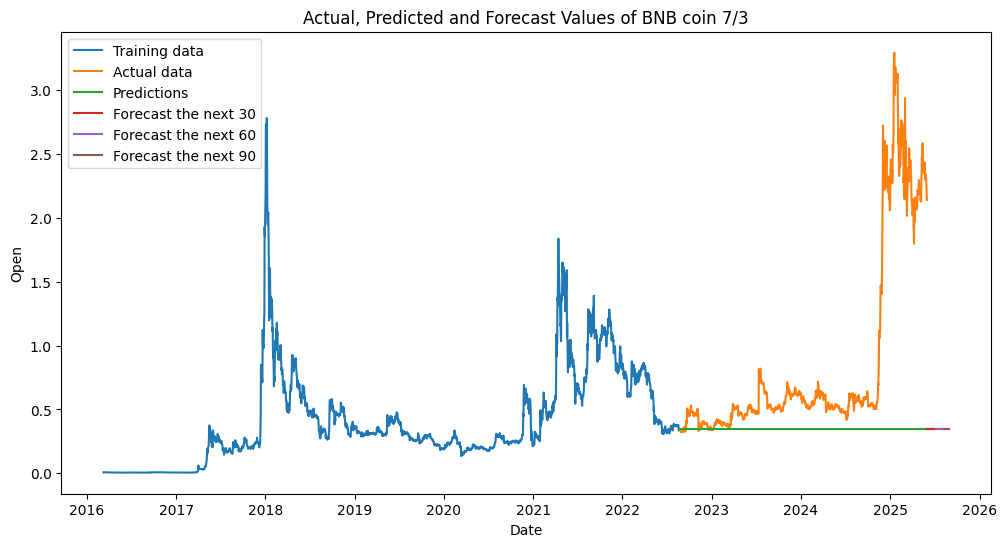

RMSE: 0.9062
MAPE: 0.41%
MSE: 0.8212


In [81]:
train_df, test_df = split_train_test(df, 0.7)

model = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model.forecast(len(test_df))

forecast_df = model.forecast(30)
last_date_df = test_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=30)

forecast_df_60 = model.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=60)

forecast_df_90 = model.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=90)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Actual, Predicted and Forecast Values of BNB coin 7/3')
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)  # Sửa lỗi tính RMSE
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

### Chia 8:2

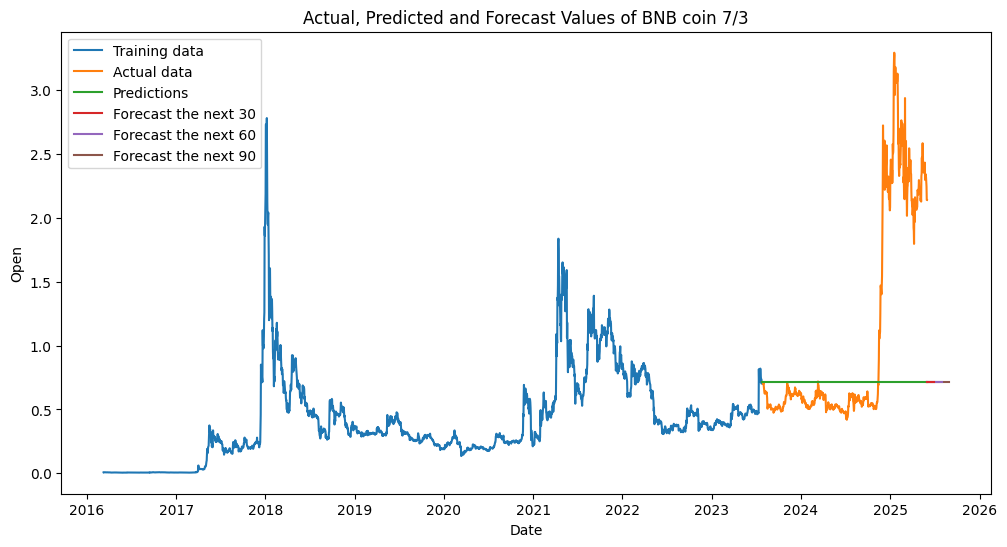

RMSE: 0.9064
MAPE: 0.41%
MSE: 0.8215


In [82]:
train_df, test_df = split_train_test(df, 0.8)

model = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model.forecast(len(test_df))

forecast_df = model.forecast(30)
last_date_df = test_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=30)

forecast_df_60 = model.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=60)

forecast_df_90 = model.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=90)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Actual, Predicted and Forecast Values of BNB coin 7/3')
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)  # Sửa lỗi tính RMSE
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")

###Chia 9:1

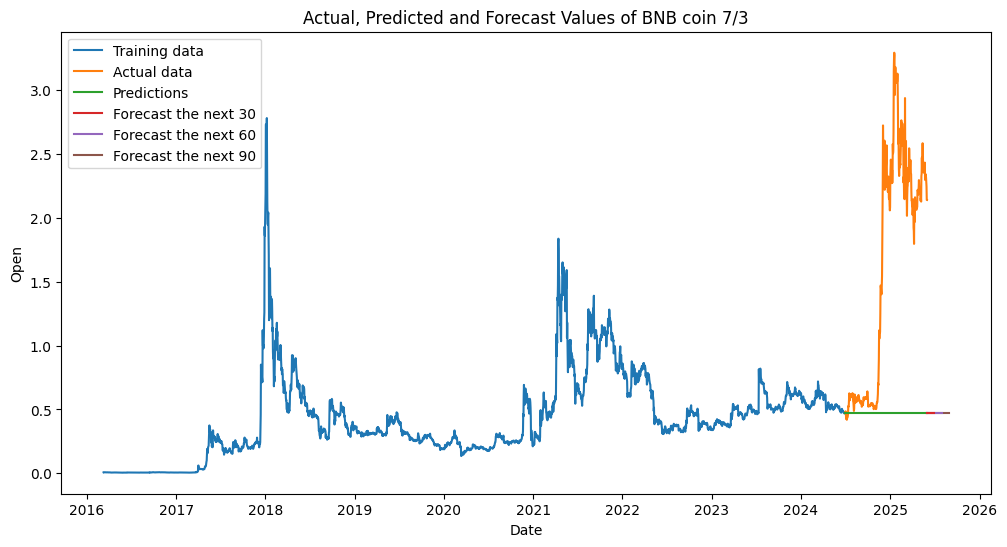

RMSE: 1.4504
MAPE: 0.53%
MSE: 2.1036


In [83]:
train_df, test_df = split_train_test(df, 0.9)

model = SimpleExpSmoothing(train_df['Price']).fit(optimized=True)
predictions_df = model.forecast(len(test_df))

forecast_df = model.forecast(30)
last_date_df = test_df['Date'].iloc[-1]
next_dates_df = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=30)

forecast_df_60 = model.forecast(60)
next_dates_df_60 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=60)

forecast_df_90 = model.forecast(90)
next_dates_df_90 = pd.date_range(start=last_date_df + pd.DateOffset(1), periods=90)

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Price'], label='Training data')
plt.plot(test_df['Date'], test_df['Price'], label='Actual data')
plt.plot(test_df['Date'], predictions_df, label='Predictions')
plt.plot(next_dates_df, forecast_df, label='Forecast the next 30', zorder = 3)
plt.plot(next_dates_df_60, forecast_df_60, label='Forecast the next 60', zorder = 2)
plt.plot(next_dates_df_90, forecast_df_90, label='Forecast the next 90', zorder = 1)
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Actual, Predicted and Forecast Values of BNB coin 7/3')
plt.legend()
plt.show()

mse_df = mean_squared_error(test_df['Price'], predictions_df)
rmse_df = np.sqrt(mse_df)  # Sửa lỗi tính RMSE
mape_df = mean_absolute_percentage_error(test_df['Price'], predictions_df)

print(f"RMSE: {rmse_df:.4f}")
print(f"MAPE: {mape_df:.2f}%")
print(f"MSE: {mse_df:.4f}")